In [1]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *  
from tensorflow.keras.callbacks import *
import tensorflow_addons as tfa
from tqdm import tqdm
import time
import random
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow_probability import distributions as tfd
import seaborn as sns
from keras.utils.np_utils import to_categorical
import pywt

# Load Data

In [2]:
## season 2 dataframes 
train_x_2 = pd.read_csv('train_x_df.csv')
train_y_2 = pd.read_csv('train_y_df.csv') 
test_x_2 = pd.read_csv('test_x_df.csv') 
submission = pd.read_csv('sample_submission.csv') 

train_x_2.shape, train_y_2.shape, test_x_2.shape, submission.shape

((10572180, 12), (919320, 12), (738300, 12), (535, 3))

In [3]:
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d


x_train = df2d_to_array3d(train_x_2) 
y_train = df2d_to_array3d(train_y_2) 
x_test = df2d_to_array3d(test_x_2) 

x_train.shape, y_train.shape, x_test.shape

((7661, 1380, 10), (7661, 120, 10), (535, 1380, 10))

In [4]:
def plot_series(x_series, y_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'actual_series') 
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()

In [5]:
def plot_predicted_series(x_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()

In [6]:
full_df = np.concatenate([x_train, y_train], axis = 1) 
full_df.shape

(7661, 1500, 10)

In [7]:
price_data = full_df[:,:,[1,2,3,4]] 

volume_data = full_df[:,:,[5,6,7,8,9]] 

id_data = full_df[:,0,0]

price_data.shape, volume_data.shape, id_data.shape

((7661, 1500, 4), (7661, 1500, 5), (7661,))

In [8]:
# min max normalize volume features, as they vary a lot in scale 
for i in tqdm(range(volume_data.shape[0])):
    for j in range(volume_data.shape[2]): 
        min_val = np.min(volume_data[i,:,j]) 
        max_val = np.max(volume_data[i,:,j]) 
        volume_data[i,:,j] = (volume_data[i,:,j] - min_val) / (max_val - min_val) 

100%|██████████| 7661/7661 [00:00<00:00, 9170.80it/s]


# Preprocess Data

In [9]:
K = 120 
N = 120  
seq_len = 1500 
features_price = 4 
features_volume = 5 
features_id = 1 
X_price = np.zeros(((seq_len-N-K)*price_data.shape[0],N,features_price)) 
X_volume = np.zeros(((seq_len-N-K)*price_data.shape[0],N,features_volume)) 
X_id = np.zeros(((seq_len-N-K)*price_data.shape[0]))
Y = np.zeros(((seq_len-N-K)*price_data.shape[0]))

cnt = 0 
for j in tqdm(range(price_data.shape[0]), position = 0, leave = True): 
    i = 0
    while i+N+K < seq_len:
        X_price[cnt,:,:] = price_data[j,i:i+N,:] 
        X_volume[cnt,:,:] = volume_data[j,i:i+N,:] 
        X_id[cnt] = id_data[j] 
        Y[cnt] = price_data[j,i+N+K,0]
        i += 1 
        cnt += 1 

X_price.shape, X_volume.shape, X_id.shape, Y.shape

100%|██████████| 7661/7661 [01:22<00:00, 93.36it/s] 


((9652860, 120, 4), (9652860, 120, 5), (9652860,), (9652860,))

# Define Model

In [10]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='glorot_uniform',
                                              trainable=True)
    
        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='glorot_uniform',
                                           trainable=True)
    
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='glorot_uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='glorot_uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config

In [11]:
# sinusoidal relative positional encoding 
def positional_encoding(max_position, d_model, min_freq=1e-4):
    position = tf.range(max_position, dtype=tf.float32)
    mask = tf.range(d_model)
    sin_mask = tf.cast(mask%2, tf.float32)
    cos_mask = 1-sin_mask
    exponent = 2*(mask//2)
    exponent = tf.cast(exponent, tf.float32)/tf.cast(d_model, tf.float32)
    freqs = min_freq**exponent
    angles = tf.einsum('i,j->ij', position, freqs)
    pos_enc = tf.math.cos(angles)*cos_mask + tf.math.sin(angles)*sin_mask
    return pos_enc

In [12]:
def transformer_block(inputs, node, drop_rate, activation): 
    attn_output = MultiHeadAttention(num_heads = 4, key_dim = node)(inputs, inputs) 
    attn_output = Dropout(drop_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    ffn_output = Dense(node, activation = activation)(out1)
    ffn_output = Dense(node)(ffn_output)
    ffn_output = Dropout(drop_rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output) 
    return out2 

def transformer_model(inputs, node=64, activation='relu', drop_rate=0.2, num_layers=3): 
    time_embedding = Time2Vector(N)
    bn = BatchNormalization()(inputs)
    x = time_embedding(bn)
    x = Concatenate()([bn, x])
    x = Conv1D(node, 5, activation=activation, padding='same')(x)
    x = MaxPooling1D()(x) 
    x = Conv1D(node*2, 5, activation=activation, padding='same')(x)
    x = MaxPooling1D()(x)
    x = Dropout(drop_rate)(x)
    positions = positional_encoding(x.shape[1], node*2)
    x = x + positions 
    for i in range(num_layers): 
        x = transformer_block(x, node*2, drop_rate, activation) 
        x = BatchNormalization()(x) 
    x = GlobalAveragePooling1D()(x) 
    return x

def build_model(node=64, activation='relu', drop_rate=0.2, num_layers=3, num_classes=10): 
    price_inputs = Input((N, features_price))
    volume_inputs = Input((N, features_volume)) 

    x_p = transformer_model(price_inputs) 
    x_v = transformer_model(volume_inputs)
    x = Concatenate()([x_p, x_v])
    x = Dense(x_p.shape[-1], activation = 'relu')(x) 
    x = BatchNormalization()(x) 
    x = Dense(x_p.shape[-1]/2, activation = 'relu')(x) 
    x = BatchNormalization()(x) 
    x = Dense(1, activation = 'relu')(x) 
    model = Model(inputs=[price_inputs, volume_inputs], outputs=x) 
    model.compile(loss='mape',optimizer='adam',metrics=['mae','mse','mape'])
    return model

In [13]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 4)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 120, 5)]     0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 120, 4)       16          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 120, 5)       20          input_2[0][0]                    
______________________________________________________________________________________________

In [14]:
model_path = 'transformer_long_range_epoch_{epoch:03d}_val_{val_loss:.3f}.h5'
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5)
checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10) 


history = model.fit([X_price, X_volume], 
                     Y, 
                     batch_size = 512, 
                     epochs = 50, 
                     callbacks = [learning_rate_reduction, checkpoint], 
                     validation_split = 0.1)


Epoch 1/50
16968/16968 [==============================] - 1198s 69ms/step - loss: 3.3658 - mae: 0.0334 - mse: 0.0110 - mape: 3.3658 - val_loss: 1.2594 - val_mae: 0.0126 - val_mse: 4.7543e-04 - val_mape: 1.2594

Epoch 00001: val_loss improved from inf to 1.25936, saving model to transformer_long_range_epoch_001_val_1.259.h5
Epoch 2/50
16968/16968 [==============================] - 1161s 68ms/step - loss: 1.5607 - mae: 0.0155 - mse: 6.6526e-04 - mape: 1.5607 - val_loss: 2.9140 - val_mae: 0.0293 - val_mse: 0.0011 - val_mape: 2.9140

Epoch 00002: val_loss did not improve from 1.25936
Epoch 3/50
16968/16968 [==============================] - 1152s 68ms/step - loss: 1.1624 - mae: 0.0117 - mse: 3.6115e-04 - mape: 1.1624 - val_loss: 1.2939 - val_mae: 0.0130 - val_mse: 4.8433e-04 - val_mape: 1.2939

Epoch 00003: val_loss did not improve from 1.25936
Epoch 4/50
 4554/16968 [=======>......................] - ETA: 13:27 - loss: 1.1128 - mae: 0.0112 - mse: 3.6141e-04 - mape: 1.1128

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



11419/16968 [===================>..........] - ETA: 6:00 - loss: 1.1167 - mae: 0.0112 - mse: 3.9938e-04 - mape: 1.1167

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16968/16968 [==============================] - 1160s 68ms/step - loss: 1.1190 - mae: 0.0112 - mse: 4.1317e-04 - mape: 1.1190 - val_loss: 1.6996 - val_mae: 0.0171 - val_mse: 9.6077e-04 - val_mape: 1.6996

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00004: val_loss did not improve from 1.25936
Epoch 5/50
 1154/16968 [=>............................] - ETA: 17:06 - loss: 1.1323 - mae: 0.0114 - mse: 3.9818e-04 - mape: 1.1323

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 8864/16968 [==============>...............] - ETA: 8:46 - loss: 1.1114 - mae: 0.0112 - mse: 3.7593e-04 - mape: 1.1114

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15790/16968 [==========================>...] - ETA: 1:17 - loss: 1.0992 - mae: 0.0110 - mse: 3.6445e-04 - mape: 1.0992

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 6294/16968 [==========>...................] - ETA: 11:50 - loss: 1.0458 - mae: 0.0105 - mse: 3.0951e-04 - mape: 1.0458

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



13147/16968 [======================>.......] - ETA: 4:13 - loss: 1.0448 - mae: 0.0105 - mse: 3.0814e-04 - mape: 1.0448

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 3299/16968 [====>.........................] - ETA: 14:49 - loss: 1.0396 - mae: 0.0104 - mse: 3.0579e-04 - mape: 1.0396

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10527/16968 [=================>............] - ETA: 6:58 - loss: 1.0376 - mae: 0.0104 - mse: 3.0857e-04 - mape: 1.0376

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16968/16968 [==============================] - 1142s 67ms/step - loss: 1.0348 - mae: 0.0104 - mse: 3.0617e-04 - mape: 1.0348 - val_loss: 1.1928 - val_mae: 0.0120 - val_mse: 4.4561e-04 - val_mape: 1.1928

Epoch 00007: val_loss improved from 1.25936 to 1.19278, saving model to transformer_long_range_epoch_007_val_1.193.h5
Epoch 8/50
  784/16968 [>.............................] - ETA: 17:32 - loss: 1.0006 - mae: 0.0100 - mse: 2.8226e-04 - mape: 1.0006

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 7341/16968 [===========>..................] - ETA: 10:24 - loss: 1.0080 - mae: 0.0101 - mse: 2.8609e-04 - mape: 1.0080

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



14553/16968 [========================>.....] - ETA: 2:36 - loss: 1.0076 - mae: 0.0101 - mse: 2.8571e-04 - mape: 1.0076

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 4614/16968 [=======>......................] - ETA: 13:30 - loss: 0.9920 - mae: 0.0099 - mse: 2.7305e-04 - mape: 0.9920

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



11828/16968 [===================>..........] - ETA: 5:34 - loss: 0.9913 - mae: 0.0099 - mse: 2.7336e-04 - mape: 0.9913

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16968/16968 [==============================] - 1156s 68ms/step - loss: 0.9907 - mae: 0.0099 - mse: 2.7343e-04 - mape: 0.9907 - val_loss: 2.2627 - val_mae: 0.0227 - val_mse: 7.9276e-04 - val_mape: 2.2627

Epoch 00009: val_loss did not improve from 1.19278
Epoch 10/50
13453/16968 [======================>.......] - ETA: 3:48 - loss: 0.9862 - mae: 0.0099 - mse: 2.7180e-04 - mape: 0.9862

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 3568/16968 [=====>........................] - ETA: 14:30 - loss: 0.9726 - mae: 0.0097 - mse: 2.6317e-04 - mape: 0.9726

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10981/16968 [==================>...........] - ETA: 6:28 - loss: 0.9713 - mae: 0.0097 - mse: 2.6174e-04 - mape: 0.9713

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16968/16968 [==============================] - 1150s 68ms/step - loss: 0.9721 - mae: 0.0097 - mse: 2.6786e-04 - mape: 0.9721 - val_loss: 1.9115 - val_mae: 0.0191 - val_mse: 6.4730e-04 - val_mape: 1.9115

Epoch 00011: val_loss did not improve from 1.19278
Epoch 12/50
 1169/16968 [=>............................] - ETA: 17:02 - loss: 0.9768 - mae: 0.0098 - mse: 2.6005e-04 - mape: 0.9768

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 8448/16968 [=============>................] - ETA: 9:11 - loss: 0.9762 - mae: 0.0098 - mse: 2.6181e-04 - mape: 0.9762

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16968/16968 [==============================] - 1155s 68ms/step - loss: 0.9748 - mae: 0.0098 - mse: 2.6190e-04 - mape: 0.9748 - val_loss: 2.6376 - val_mae: 0.0264 - val_mse: 0.0010 - val_mape: 2.6376

Epoch 00012: val_loss did not improve from 1.19278
Epoch 13/50
  835/16968 [>.............................] - ETA: 17:24 - loss: 0.9657 - mae: 0.0097 - mse: 2.5675e-04 - mape: 0.9657

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 7836/16968 [============>.................] - ETA: 9:49 - loss: 0.9678 - mae: 0.0097 - mse: 2.5856e-04 - mape: 0.9678

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15250/16968 [=========================>....] - ETA: 1:51 - loss: 0.9676 - mae: 0.0097 - mse: 2.5835e-04 - mape: 0.9676

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 5487/16968 [========>.....................] - ETA: 12:23 - loss: 0.9606 - mae: 0.0096 - mse: 2.5884e-04 - mape: 0.9606

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



12835/16968 [=====================>........] - ETA: 4:27 - loss: 0.9622 - mae: 0.0096 - mse: 2.6477e-04 - mape: 0.9622

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 3008/16968 [====>.........................] - ETA: 15:00 - loss: 0.9709 - mae: 0.0097 - mse: 2.6632e-04 - mape: 0.9709

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16968/16968 [==============================] - 1156s 68ms/step - loss: 0.9703 - mae: 0.0097 - mse: 2.6634e-04 - mape: 0.9703 - val_loss: 1.9792 - val_mae: 0.0198 - val_mse: 7.1550e-04 - val_mape: 1.9792

Epoch 00015: val_loss did not improve from 1.19278
Epoch 16/50
  320/16968 [..............................] - ETA: 17:53 - loss: 0.9649 - mae: 0.0097 - mse: 2.5980e-04 - mape: 0.9649

KeyboardInterrupt: 

# Make Prediction

In [15]:
best_model = load_model('transformer_long_range_epoch_007_val_1.193.h5',custom_objects={'Time2Vector':Time2Vector}) 
best_model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 4)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 120, 5)]     0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 120, 4)       16          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 120, 5)       20          input_2[0][0]                    
______________________________________________________________________________________________

In [16]:
x_test_price = x_test[:,:,[1,2,3,4]] 
x_test_volume = x_test[:,:,[5,6,7,8,9]] 
x_test_id = x_test[:,0,0] 

## min-max scale volume 
for i in tqdm(range(x_test_volume.shape[0])):
    for j in range(x_test_volume.shape[2]):  
        min_val = np.min(x_test_volume[i,:,j]) 
        max_val = np.max(x_test_volume[i,:,j])
        x_test_volume[i,:,j] = (x_test_volume[i,:,j] - min_val) / (max_val - min_val) 
        
x_test_price.shape, x_test_volume.shape, x_test_id.shape 

100%|██████████| 535/535 [00:00<00:00, 8645.75it/s]


((535, 1380, 4), (535, 1380, 5), (535,))

In [17]:
X_test_price = np.zeros((120*x_test_price.shape[0],N,features_price)) 
X_test_volume = np.zeros((120*x_test_volume.shape[0],N,features_volume)) 
X_test_id = np.zeros((120*x_test_price.shape[0])) 

cnt = 0 
for j in tqdm(range(x_test.shape[0]), position = 0, leave=True): 
    for i in range(seq_len-K-N-120, seq_len-K-N): 
        X_test_price[cnt,:,:] = x_test_price[j,i:i+N,:]  
        X_test_volume[cnt,:,:] = x_test_volume[j,i:i+N,:]
        X_test_id[cnt] = x_test_id[j] 
        cnt += 1 

X_test_price.shape, X_test_volume.shape, X_test_id.shape

100%|██████████| 535/535 [00:00<00:00, 930.31it/s]


((64200, 120, 4), (64200, 120, 5), (64200,))

In [18]:
predicted = best_model.predict([X_test_price, X_test_volume])
predicted = predicted.reshape((-1,120))
predicted.shape 

(535, 120)

In [19]:
x_test_open = x_test[:,:,1] 

## Adjust predicted prices to be connected with the buy price 
for i in tqdm(range(predicted.shape[0]), position = 0, leave = True):
    buy_price = x_test_open[i,-1] 
    if predicted[i,0] > buy_price:
        diff = predicted[i,0] - buy_price 
        predicted[i,:] -= diff 
    elif predicted[i,0] < buy_price:  
        diff = buy_price - predicted[i,0] 
        predicted[i,:] += diff


100%|██████████| 535/535 [00:00<00:00, 121085.29it/s]


In [20]:
## create submission dataframe version 1 
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(predicted.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(predicted[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_open[i,-1] 
    cnt = 0 
    for j in range(120): 
        if predicted[i,j] >= buy_price:    
            cnt += 1 
    buy_quantity = cnt/120 
    buy_quantities.append(buy_quantity)
    
submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times  
submission.to_csv('transformers_with_id.csv',index=False)


100%|██████████| 535/535 [00:00<00:00, 3660.94it/s]


In [21]:
submission

,sample_id,buy_quantity,sell_time
0,7661,0.875000,98
1,7662,0.941667,34
2,7663,0.975000,84
3,7664,0.150000,15
4,7665,0.850000,119
...,...,...,...
530,8191,0.116667,9
531,8192,0.158333,113
532,8193,0.875000,73
533,8194,0.033333,1


In [45]:
submission

,sample_id,buy_quantity,sell_time
0,7661,0.975000,105
1,7662,0.941667,42
2,7663,1.000000,84
3,7664,0.233333,15
4,7665,0.700000,119
...,...,...,...
530,8191,0.066667,6
531,8192,0.025000,1
532,8193,0.908333,74
533,8194,0.025000,1


# Visualize Predictions

In [22]:
pred_train = best_model.predict([X_price[:3600,], X_volume[:3600,]])
pred_train = pred_train.reshape((-1,120))
pred_train.shape

(30, 120)

In [23]:
# shifting predicted value to be continuous with the original series.  
x_train_open = x_train[:,:,1]

for i in tqdm(range(pred_train.shape[0]), position = 0, leave = True): 
    buy_price = x_train_open[i,-1] 
    if pred_train[i,0] > buy_price:
        diff = pred_train[i,0] - buy_price 
        pred_train[i,:] -= diff 
    elif pred_train[i,0] < buy_price:  
        diff = buy_price - pred_train[i,0] 
        pred_train[i,:] += diff


100%|██████████| 30/30 [00:00<00:00, 29160.86it/s]


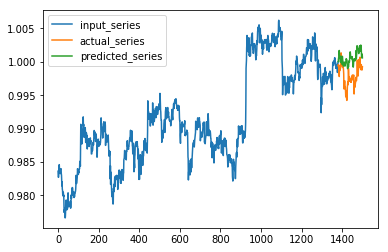

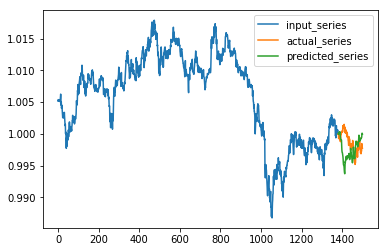

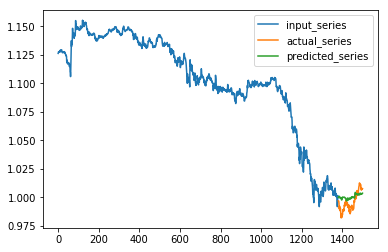

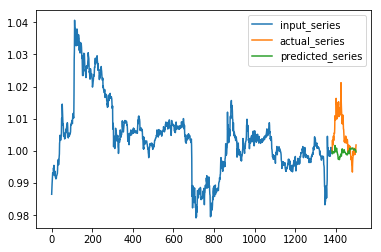

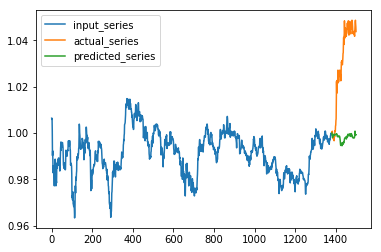

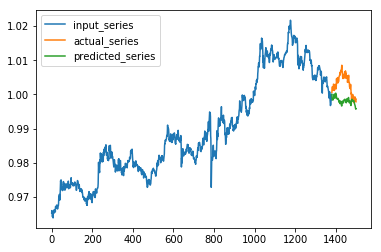

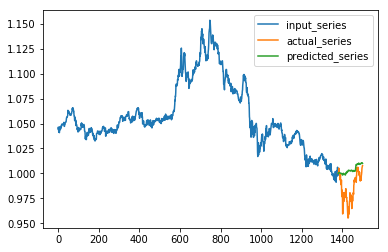

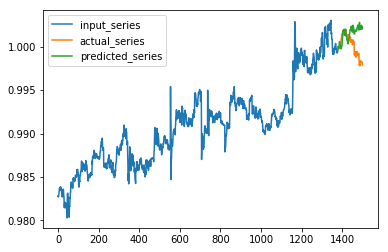

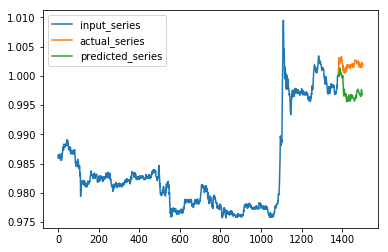

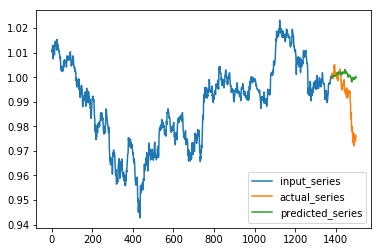

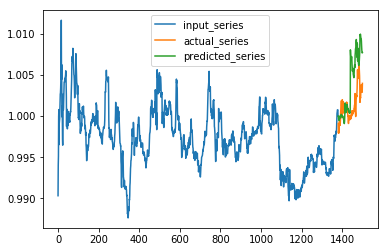

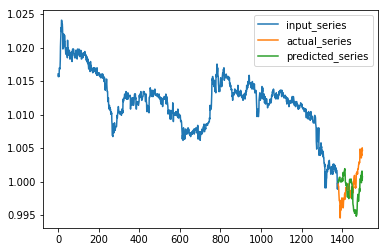

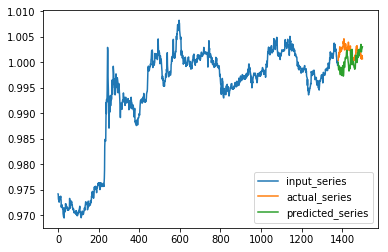

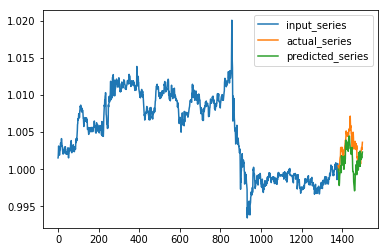

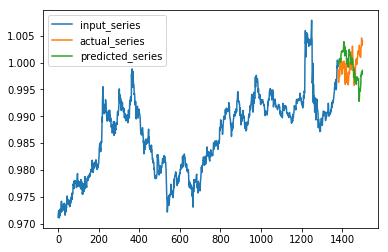

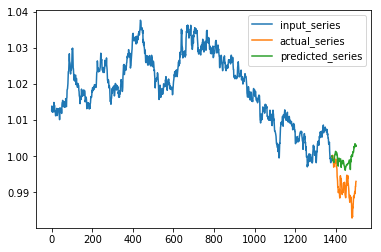

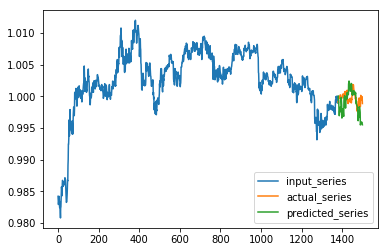

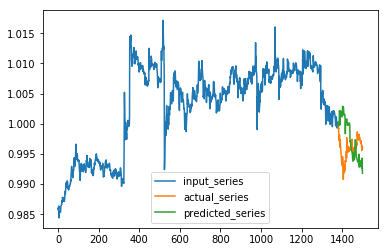

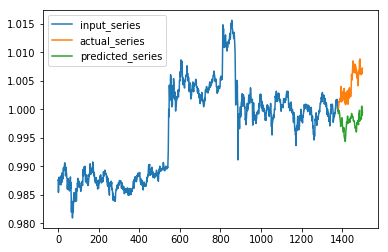

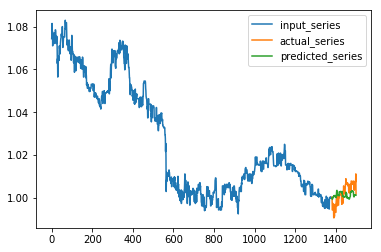

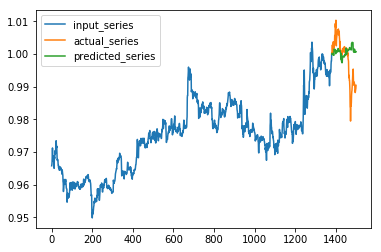

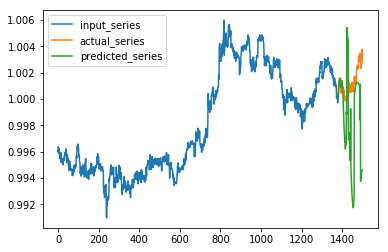

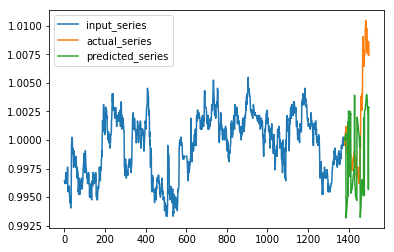

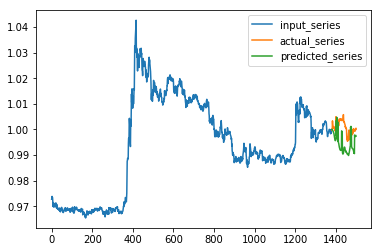

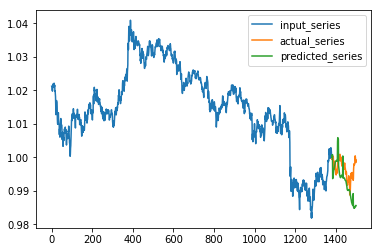

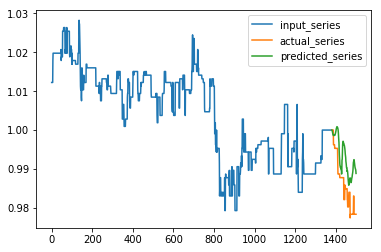

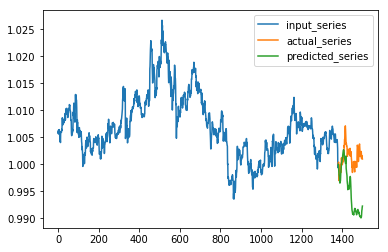

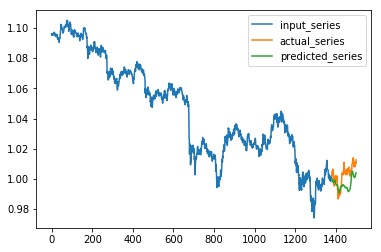

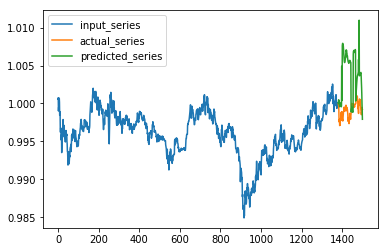

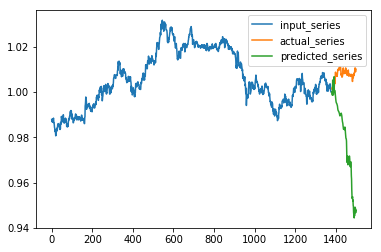

In [24]:
y_train_open = y_train[:,:,1]

for i in range(30): 
    plt.plot() 
    plot_series(x_train_open[i,:], y_train_open[i,:], pred_train[i,:])
    plt.show()

In [25]:
## max ensemble 

df1 = pd.read_csv('transformers_full_features.csv') 
df2 = pd.read_csv('transformers_with_id.csv')

In [26]:
df2

,sample_id,buy_quantity,sell_time
0,7661,0.875000,98
1,7662,0.941667,34
2,7663,0.975000,84
3,7664,0.150000,15
4,7665,0.850000,119
...,...,...,...
530,8191,0.116667,9
531,8192,0.158333,113
532,8193,0.875000,73
533,8194,0.033333,1


In [27]:
df1

,sample_id,buy_quantity,sell_time
0,7661,0.850000,105
1,7662,1.000000,54
2,7663,0.966667,106
3,7664,0.341667,23
4,7665,0.841667,56
...,...,...,...
530,8191,0.016667,1
531,8192,0.016667,4
532,8193,0.741667,93
533,8194,0.133333,14


In [28]:
bq = [] 
st = [] 
df1_bq = df1['buy_quantity'].values 
df1_st = df1['sell_time'].values 

df2_bq = df2['buy_quantity'].values 
df2_st = df2['sell_time'].values 

In [31]:
df1_bq.shape

(535,)

In [32]:
for i in tqdm(range(df1_bq.shape[0])): 
    if df1_bq[i] > df2_bq[i]:  
        bq.append(df1_bq[i]) 
        st.append(df1_st[i])
    else: 
        bq.append(df2_bq[i]) 
        st.append(df2_st[i]) 


100%|██████████| 535/535 [00:00<00:00, 539411.69it/s]


In [34]:
submission.iloc[:,1] = bq 
submission.iloc[:,2] = st

In [35]:
submission

,sample_id,buy_quantity,sell_time
0,7661,0.875000,98
1,7662,1.000000,54
2,7663,0.975000,84
3,7664,0.341667,23
4,7665,0.850000,119
...,...,...,...
530,8191,0.116667,9
531,8192,0.158333,113
532,8193,0.875000,73
533,8194,0.133333,14


In [36]:
submission.to_csv('max_ensemble.csv',index=False)